In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Input, Conv2D, MaxPool2D, Dropout, BatchNormalization, Layer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC, FalseNegatives, FalsePositives, TruePositives, TrueNegatives
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [1]:
dataset, dataset_info

NameError: name 'dataset' is not defined

In [4]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):


  dataset_size = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * dataset_size))
  # print(list(train_dataset.take(1).as_numpy_iterator()))

  val_dataset = dataset.skip(int(TRAIN_RATIO * dataset_size))
  val_dataset = val_dataset.take(int(VAL_RATIO * dataset_size))
  # print(list(val_dataset.take(1).as_numpy_iterator()))

  test_dataset = dataset.skip(int((TRAIN_RATIO + VAL_RATIO)* dataset_size))
  # print(list(test_dataset.take(1).as_numpy_iterator()))

  return train_dataset, val_dataset, test_dataset

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1


train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

2024-07-15 10:21:24.777373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


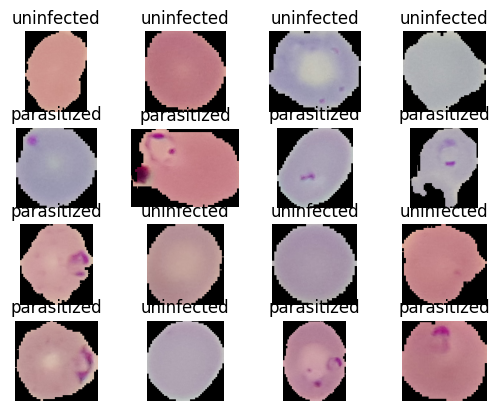

In [6]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [7]:
IM_SIZE = 224
def resize_normalize(image, label):
  image = tf.image.resize(image, [IM_SIZE, IM_SIZE])/255
  return image, label

In [8]:
train_dataset = train_dataset.map(resize_normalize)
val_dataset = val_dataset.map(resize_normalize)
test_dataset = test_dataset.map(resize_normalize)

In [9]:
for image, label in train_dataset.take(2):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0

2024-07-15 10:21:28.412471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

(16, 224, 224, 3)


2024-07-15 10:21:31.325011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


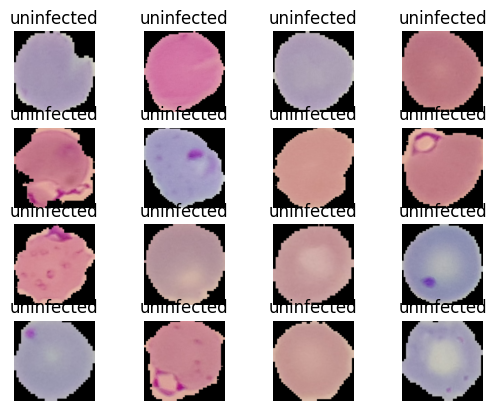

In [13]:
for i, (image, label) in enumerate(train_dataset.take(1)):
  print(image[0:16, :, :, :].shape)
  for j in range(16):
    plt.subplot(4, 4, j+1)
    plt.imshow(image[j, :, :, :])
    plt.title(dataset_info.features['label'].int2str(label[0]))
    plt.axis('off')

In [14]:
linnetmodel = tf.keras.Sequential([
    InputLayer(shape=[IM_SIZE, IM_SIZE, 3]),

    Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')


])

linnetmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 220, 220, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 106, 106, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,494,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

### Functional Method of Building Neural Nets

In [15]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name='Lenet Model')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

Feature_Extractor = Model(func_input, output, name='Feature_Extractor')

Feature_Extractor.summary()

Model: "Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Lenet Model (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,092 (4.27 KB)

 Non-trainable params: 44 (176.00 B)

In [16]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name='Lenet Model')

x = Feature_Extractor(func_input)

x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

lenetmodel = Model(func_input, func_output, name='lenetmodel')

lenetmodel.summary()

Model: "lenetmodel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Lenet Model (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Feature_Extractor (Functional)  │ (None, 54, 54, 16)     │         1,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

#### Sub Classing Method

In [17]:
class Feature_Extractor_SUB_CLASSED(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(Feature_Extractor_SUB_CLASSED, self).__init__()

    self.conv1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.bn1 = BatchNormalization()
    self.maxpool1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv2 = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.bn2 = BatchNormalization()
    self.maxpool2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

  def call(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.maxpool2(x)

    return x

feature_extractor_sub_classed = Feature_Extractor_SUB_CLASSED(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu', pool_size=2)

In [18]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name='Input Image')

x = feature_extractor_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation='sigmoid')(x)

lenetmodel = Model(func_input, func_output, name='lenetmodel')

lenetmodel.summary()

Model: "lenetmodel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature__extractor_sub_classed  │ (None, 54, 54, 16)     │         1,488 │
│ (Feature_Extractor_SUB_CLASSED) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,649 (17.81 MB)

 Trainable params: 4,668,381 (17.81 MB)

 Non-trainable params: 268 (1.05 KB)

###### Custom Layers

In [19]:
class NeuralearnDense(Layer):
  def __init__(self, output_units, activation=None):
    super(NeuralearnDense, self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer='random_normal', trainable = True)
    self.b = self.add_weight(shape = (self.output_units, ), initializer='random_normal', trainable=True)

  def call(self, input_features):
    if (self.activation == 'relu'):
      return tf.nn.relu(tf.matmul(input_features, self.w) + self.b)
    elif (self.activation == 'sigmoid'):
      return tf.math.sigmoid(tf.matmul(input_features, self.w) + self.b)
    else:
      return tf.matmul(input_features, self.w) + self.b

In [20]:
linnetmodel = tf.keras.Sequential([
    InputLayer(input_shape=[IM_SIZE, IM_SIZE, 3]),

    Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    NeuralearnDense(100, activation='relu'),
    BatchNormalization(),
    NeuralearnDense(10, activation='relu'),
    BatchNormalization(),
    NeuralearnDense(1, activation='sigmoid')


])

linnetmodel.summary()

/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 220, 220, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 106, 106, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense                │ (None, 100)            │     4,494,500 │
│ (NeuralearnDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense_1              │ (None, 10)             │         1,010 │
│ (NeuralearnDense)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neuralearn_dense_2              │ (None, 1)              │            11 │
│ (NeuralearnDense)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

In [21]:
metrics = [BinaryAccuracy(name="accuracy"), Precision(name="precision"), Recall(name="recall"), AUC(name="auc"), FalseNegatives(name="fn"), FalsePositives(name="fp"), TruePositives(name="tp"), TrueNegatives(name="tn")]
lenetmodel.compile(optimizer=Adam(learning_rate=0.01), loss = BinaryCrossentropy(), metrics=metrics)

In [22]:
lenethistory=lenetmodel.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5


366/689 ━━━━━━━━━━━━━━━━━━━━ 7:28 1s/step - accuracy: 0.6412 - auc: 0.6901 - fn: 1046.0984 - fp: 986.1011 - loss: 0.6481 - precision: 0.6488 - recall: 0.6382 - tn: 1933.0574 - tp: 1906.7432

2024-07-15 10:30:14.953155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: DATA_LOSS: corrupted record at 35574192
	 [[{{node IteratorGetNext}}]]


DataLossError: Graph execution error:

Detected at node IteratorGetNext defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_78813/1399227677.py", line 1, in <module>

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/home/sco/Music/DeepLearningTut/NeuraLearn/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 120, in one_step_on_iterator

corrupted record at 35574192
	 [[{{node IteratorGetNext}}]] [Op:__inference_one_step_on_iterator_6550]

In [ ]:
def plot_history(history, type:str, train_history:str, val_history:str):
  plt.plot(history.history[train_history])
  plt.plot(history.history[val_history])
  plt.title(f'Model {type}')
  plt.ylabel(type)
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')

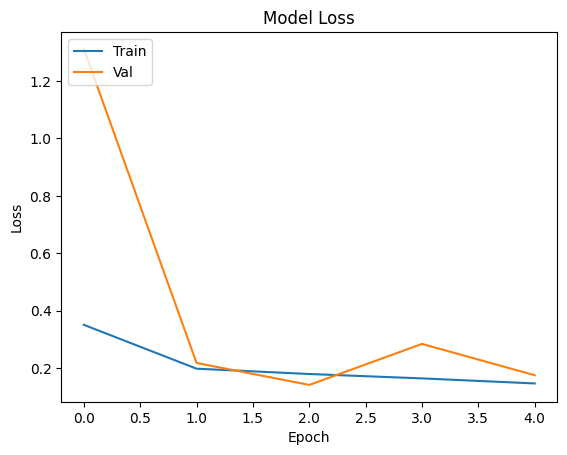

In [ ]:
plot_history(lenethistory, 'Loss', 'loss', 'val_loss')

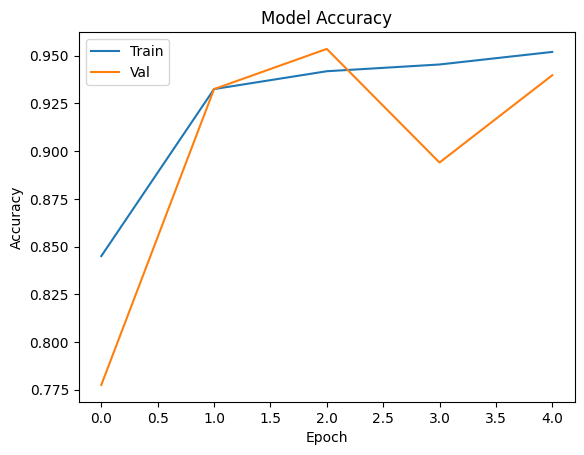

In [ ]:
plot_history(lenethistory, 'Accuracy', 'accuracy', 'val_accuracy')

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
lenetmodel.evaluate(test_dataset)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.9337 - auc: 0.9753 - fn: 20.5724 - fp: 73.6217 - loss: 0.1940 - precision: 0.9054 - recall: 0.9716 - tn: 610.7900 - tp: 674.0156


[0.19941170513629913,
 0.9303337931632996,
 0.8972278833389282,
 0.9707388281822205,
 0.9746494889259338,
 40.0,
 152.0,
 1327.0,
 1237.0]

In [ ]:
labels = []
inp = []

for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

2024-07-15 10:08:10.293768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
print(np.array(inp).shape)
print(np.array(inp)[:,0,...].shape)

(2756, 1, 224, 224, 3)
(2756, 224, 224, 3)


In [ ]:
predicted = lenetmodel.predict(np.array(inp)[:,0,...])

2024-07-15 10:08:11.518829: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1659420672 exceeds 10% of free system memory.


87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step


In [ ]:
print(predicted[:,0].shape)

(2756,)


[[1235  156]
 [  36 1329]]


Text(0.5, 80.7222222222222, 'Predicted')

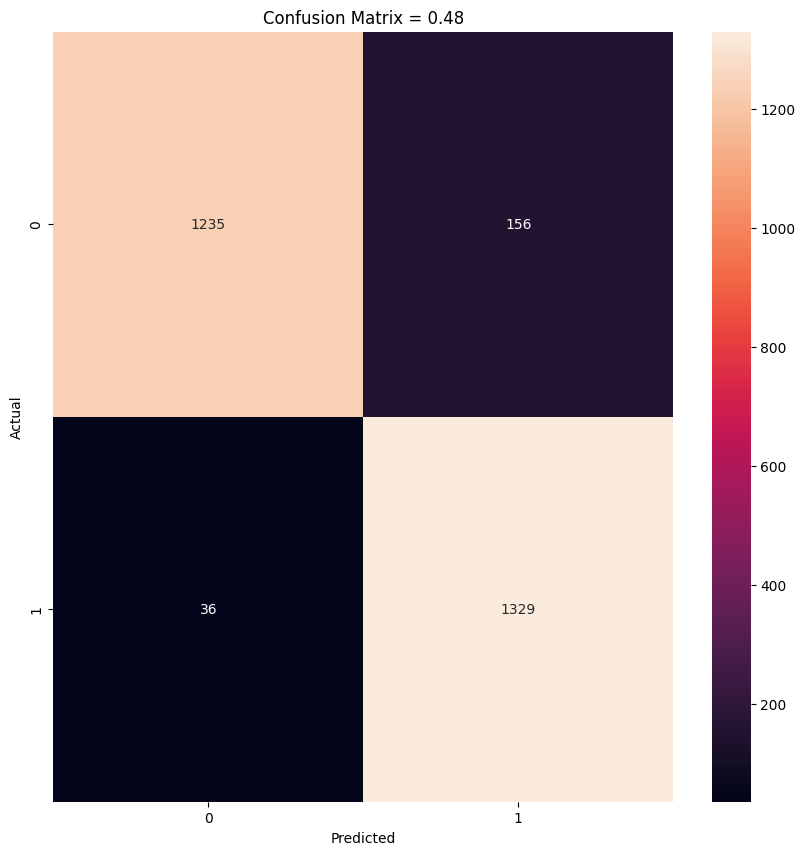

In [ ]:
threshold = 0.48

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

fig,ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm, annot=True, fmt=".4g")
plt.title('Confusion Matrix = {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

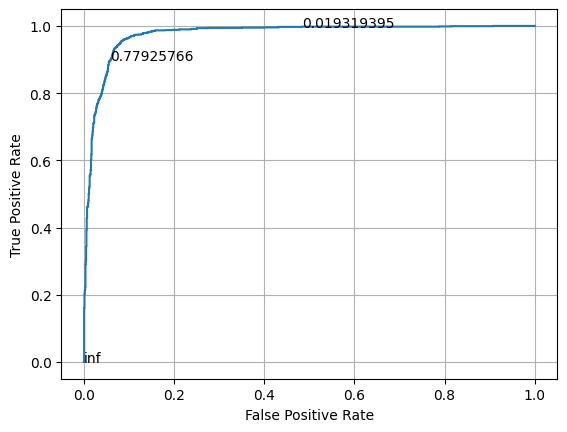

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.grid()

skip = 150

for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])
    
plt.show()

### CallBack

In [ ]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print("For epoch number {} the model has a loss of {}".format(epoch+1, logs["loss"]))
        
    def on_batch_end(self, batch, logs):
        print("For batch number {} the model has a loss of {}".format(batch+1, logs))

In [27]:
csv_callback = CSVLogger(
    
    'logs.csv', separator=",", append=False
)

In [ ]:
es_callback = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=2, verbose=1, mode='auto', baseline=None, restore_best_weights=False
)

In [28]:
def schedule(epoch, lr):
    if epoch < 3: 
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    

lr_scheduler_callback = LearningRateScheduler(
    schedule, verbose=1
)

In [29]:
lenethistory=lenetmodel.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks=[csv_callback, lr_scheduler_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7864 - auc: 0.8615 - fn: 1007.0755 - fp: 977.4369 - loss: 0.4497 - precision: 0.7907 - recall: 0.7837 - tn: 4533.4429 - tp: 4522.0420

2024-07-15 10:47:21.960749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:48: Filling up shuffle buffer (this may take a while): 1 of 8
2024-07-15 10:47:21.965841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


689/689 ━━━━━━━━━━━━━━━━━━━━ 756s 1s/step - accuracy: 0.7865 - auc: 0.8616 - fn: 1007.7797 - fp: 978.2652 - loss: 0.4495 - precision: 0.7908 - recall: 0.7838 - tn: 4540.6030 - tp: 4529.2998 - val_accuracy: 0.9212 - val_auc: 0.9619 - val_fn: 29.0000 - val_fp: 188.0000 - val_loss: 0.2500 - val_precision: 0.8792 - val_recall: 0.9792 - val_tn: 1170.0000 - val_tp: 1368.0000 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 645s 869ms/step - accuracy: 0.9332 - auc: 0.9717 - fn: 351.7348 - fp: 396.7159 - loss: 0.1989 - precision: 0.9304 - recall: 0.9375 - tn: 5121.9756 - tp: 5185.5220 - val_accuracy: 0.9191 - val_auc: 0.9657 - val_fn: 31.0000 - val_fp: 192.0000 - val_loss: 0.3334 - val_precision: 0.8768 - val_recall: 0.9778 - val_tn: 1166.0000 - val_tp: 1366.0000 - learning_rate: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━

ValueError: The output of the `schedule` function should be a float. Got: 0.009048374369740486